In [86]:
import torch
import torch.nn as nn # neural network
import torch.optim as optim #optimizer
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm #for image classification
from tqdm.notebook import tqdm
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [87]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gpiosenka/cards-image-datasetclassification")

print("Path to dataset files:", path)
folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
print("Folders inside the dataset path:", folders)

Path to dataset files: /root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2
Folders inside the dataset path: ['valid', 'train', 'test']


# New Section

In [88]:
class PlayingCardDataset(Dataset):
  def __init__(self, data_dir, transform=None):
    self.data= ImageFolder(data_dir, transform=transform)#this image folder class will assume that every folder name is the class of the images inside and will create labels

  def __len__(self): #imp for dataloader to know how many record in dataset
    return len(self.data)

  def __getitem__(self, idx): #takes index of location of item in dataset and returns the item
    return self.data[idx]

  @property
  def classes(self):
    return self.data.classes

In [89]:
print(path)

/root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2


In [90]:
dataset= PlayingCardDataset(data_dir=path+'/train')

In [91]:
print(dataset.classes)

['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs', 'eight of diamonds', 'eight of hearts', 'eight of spades', 'five of clubs', 'five of diamonds', 'five of hearts', 'five of spades', 'four of clubs', 'four of diamonds', 'four of hearts', 'four of spades', 'jack of clubs', 'jack of diamonds', 'jack of hearts', 'jack of spades', 'joker', 'king of clubs', 'king of diamonds', 'king of hearts', 'king of spades', 'nine of clubs', 'nine of diamonds', 'nine of hearts', 'nine of spades', 'queen of clubs', 'queen of diamonds', 'queen of hearts', 'queen of spades', 'seven of clubs', 'seven of diamonds', 'seven of hearts', 'seven of spades', 'six of clubs', 'six of diamonds', 'six of hearts', 'six of spades', 'ten of clubs', 'ten of diamonds', 'ten of hearts', 'ten of spades', 'three of clubs', 'three of diamonds', 'three of hearts', 'three of spades', 'two of clubs', 'two of diamonds', 'two of hearts', 'two of spades']


In [92]:
len(dataset)

7624

In [93]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=224x224>, 0)

In [94]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),#making sure that input is consistent
    transforms.ToTensor(),
])

data_dir=path
dataset = PlayingCardDataset(data_dir, transform)

In [95]:
image, label = dataset[100]


In [96]:
image.shape

torch.Size([3, 128, 128])

In [97]:
image

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

In [98]:
#iterate over dataset
for image, label in dataset:
    break

DataLoaders
* Batching our dataset

In [99]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [100]:
for images, labels in dataloader:
    break

In [101]:
image.shape, labels.shape

(torch.Size([3, 128, 128]), torch.Size([32]))

In [102]:
labels

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1])

> Recap
1. we need first to create a pytorch dataset before we train our model, by inheriting from Dataset class that creates an  iterable object that we can loop over
2. create pytorch dataloader that handles batching items in dataset when feeding into model, we do this because model trains faster when it takes batchs of examples of all one time

**Step 2: Pytorch Model**


In [103]:
class SimpleCardClassifier(nn.Module):
    def __init__(self, num_classes=53): #where we define all the parts of the model
        super(SimpleCardClassifier, self).__init__()
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        enet_out_size = 1280
        #make the classifier
        self.classifier = nn.Linear(enet_out_size, num_classes)

    def forward(self, x): #connect batches and return output
        x= self.features(x)
        output = self.classifier(x)
        return output

In [104]:
model = SimpleCardClassifier(num_classes=53)
print(str(model)[:500])

SimpleCardClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fa


In [105]:
example_output = model(images)
example_output.shape #[batch_size, num_classes]

torch.Size([32, 53])

In [106]:
model(images)

tensor([[-0.0531,  0.0565,  0.0043,  ..., -0.3362,  0.3776,  0.3312],
        [-0.4218, -0.1742,  0.4071,  ..., -0.1507,  0.2171, -0.0186],
        [-0.1261,  0.0722, -0.0894,  ..., -0.3954,  0.5182,  0.3936],
        ...,
        [ 0.0099, -0.4145,  0.1026,  ...,  0.1320,  0.0186,  0.2457],
        [ 0.4213, -0.1299,  0.1612,  ...,  0.2788, -0.1262,  0.5472],
        [-0.2112,  0.5955, -0.0094,  ...,  0.0701,  0.1770,  0.2151]],
       grad_fn=<AddmmBackward0>)

In [107]:
#loss function
criterion = nn.CrossEntropyLoss()
optimizer= optim.Adam(model.parameters(), lr=0.001)

In [108]:
criterion(example_output, labels)

tensor(3.9942, grad_fn=<NllLossBackward0>)

In [109]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = path+'/train/'
validate_folder = path+'/valid/'
test_folder = path+'/test/'

train_dataset = PlayingCardDataset(train_folder, transform=transform)
validate_dataset = PlayingCardDataset(validate_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [110]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

cuda


In [111]:
# one epoch is one run through the dataset
num_epoch = 5
train_losses, val_losses = [], []

model = SimpleCardClassifier(num_classes=53)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epoch):#set the model to train
    model.train()
    running_loss = 0
    for images, labels in tqdm(train_loader, desc='Training'):
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item() + labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    #validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
      for images, labels in tqdm(validate_loader, desc='Validation'):
        # Move images and labels to the device (GPU)
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(validate_loader.dataset)
    val_losses.append(val_loss)

    #print epoch stats
    print(f"Epoch {epoch+1}/{num_epoch} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 - Train Loss: 1.0468 - Val Loss: 0.3403


Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 - Train Loss: 1.0164 - Val Loss: 0.1985


Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 - Train Loss: 1.0102 - Val Loss: 0.1969


Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 - Train Loss: 1.0072 - Val Loss: 0.2863


Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 - Train Loss: 1.0063 - Val Loss: 0.1958


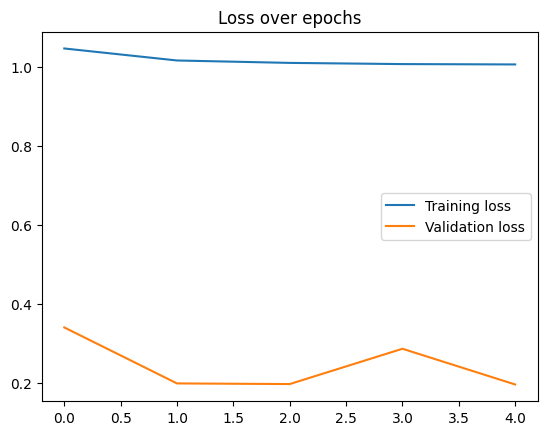

In [112]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

evaluate results

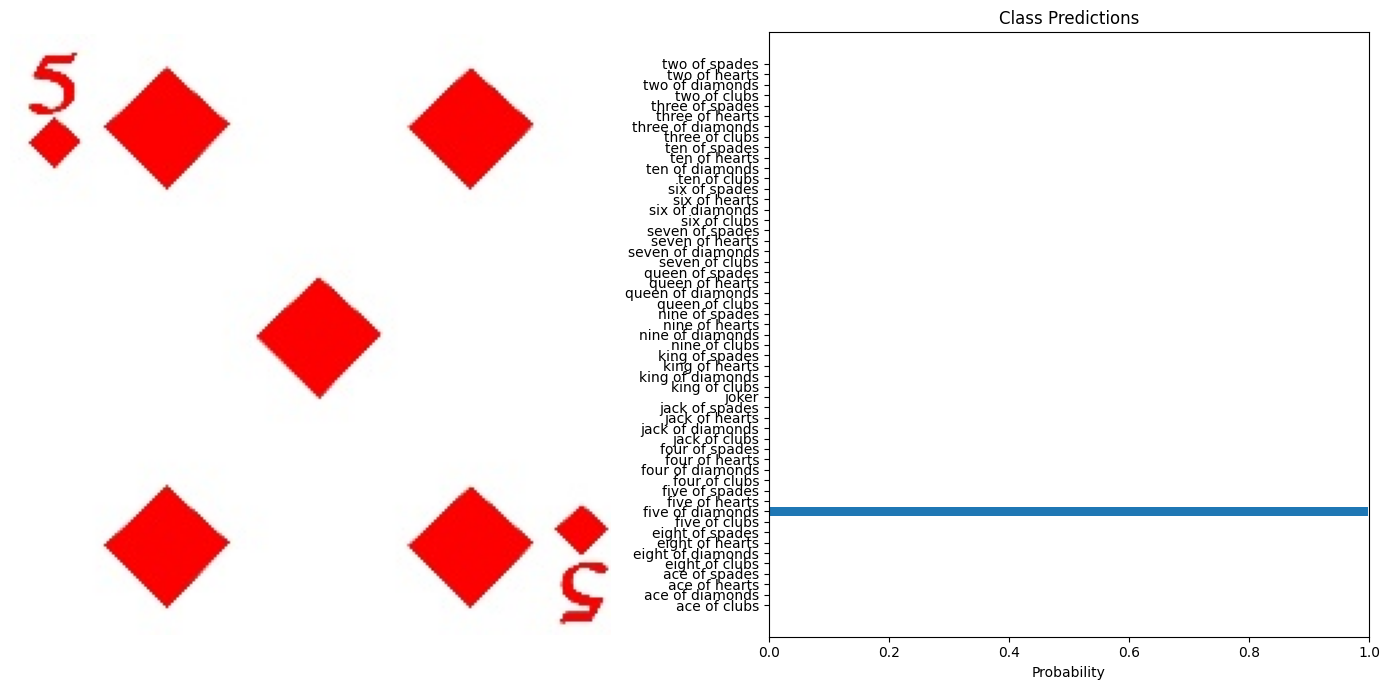

In [114]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))

    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")

    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = path+"/test/five of diamonds/2.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = train_dataset.classes
visualize_predictions(original_image, probabilities, class_names)

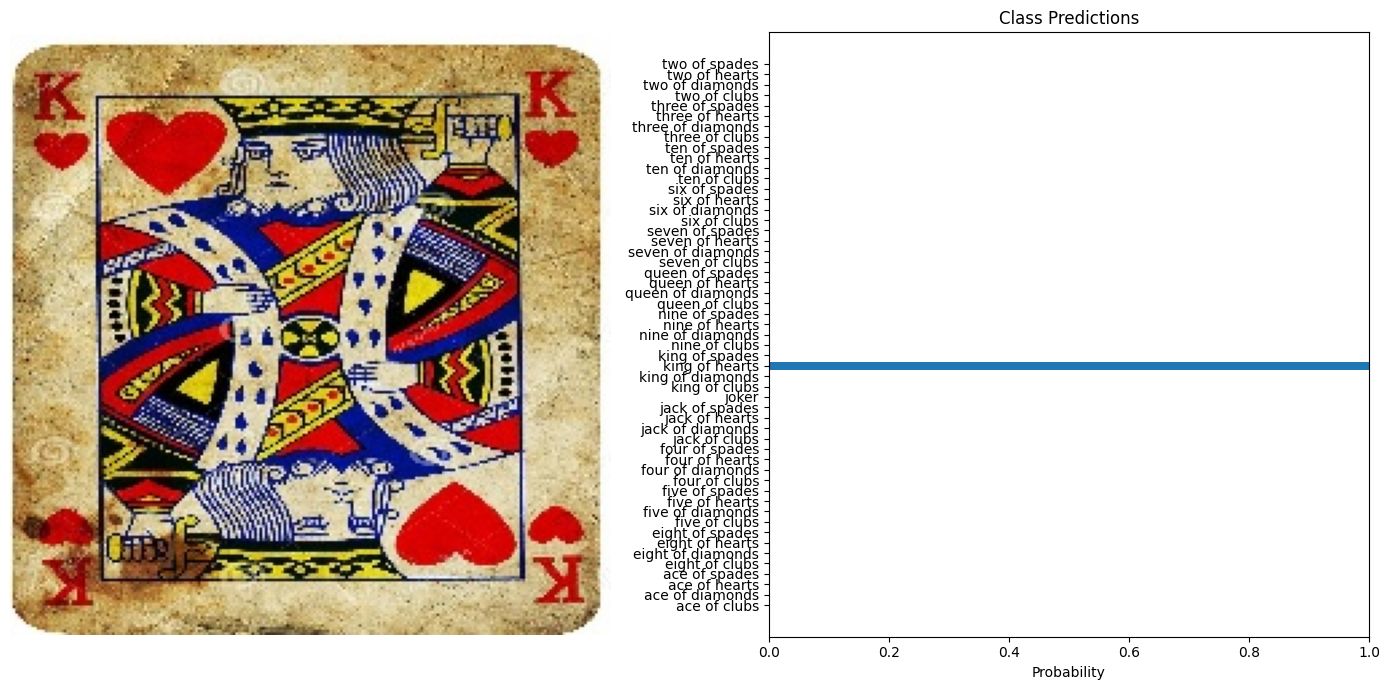

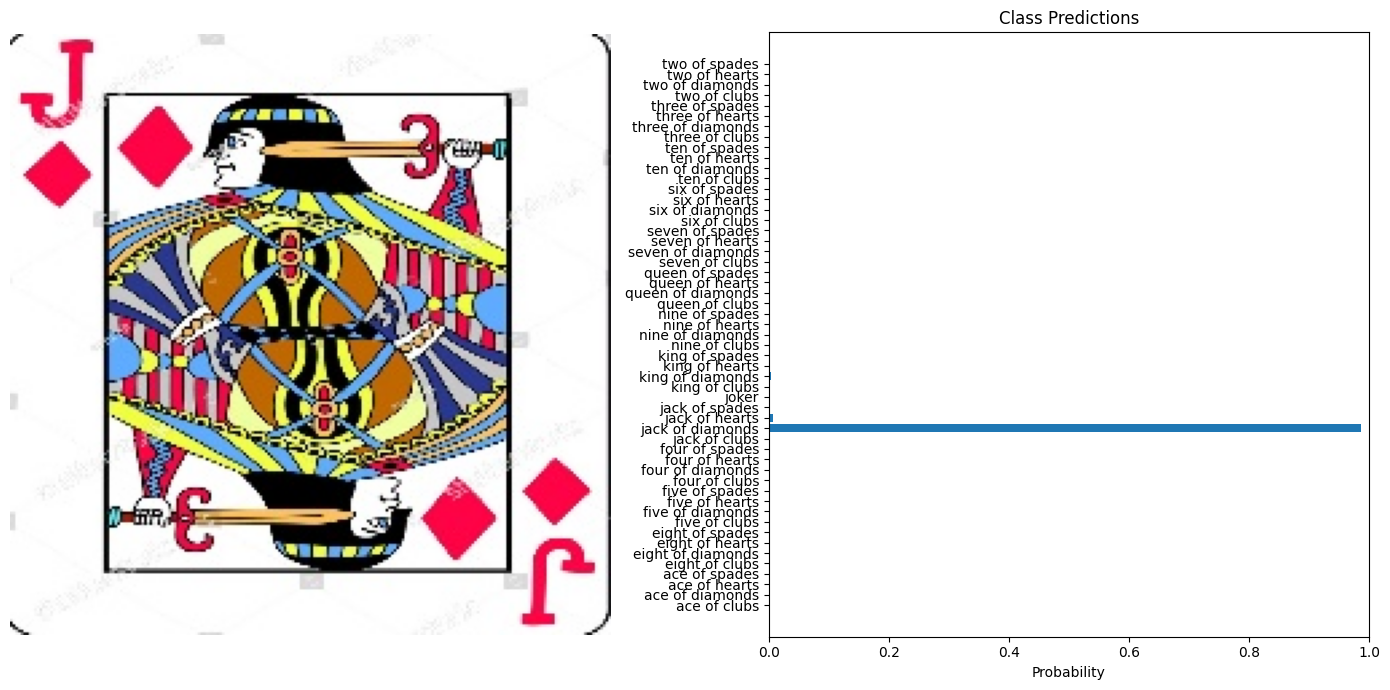

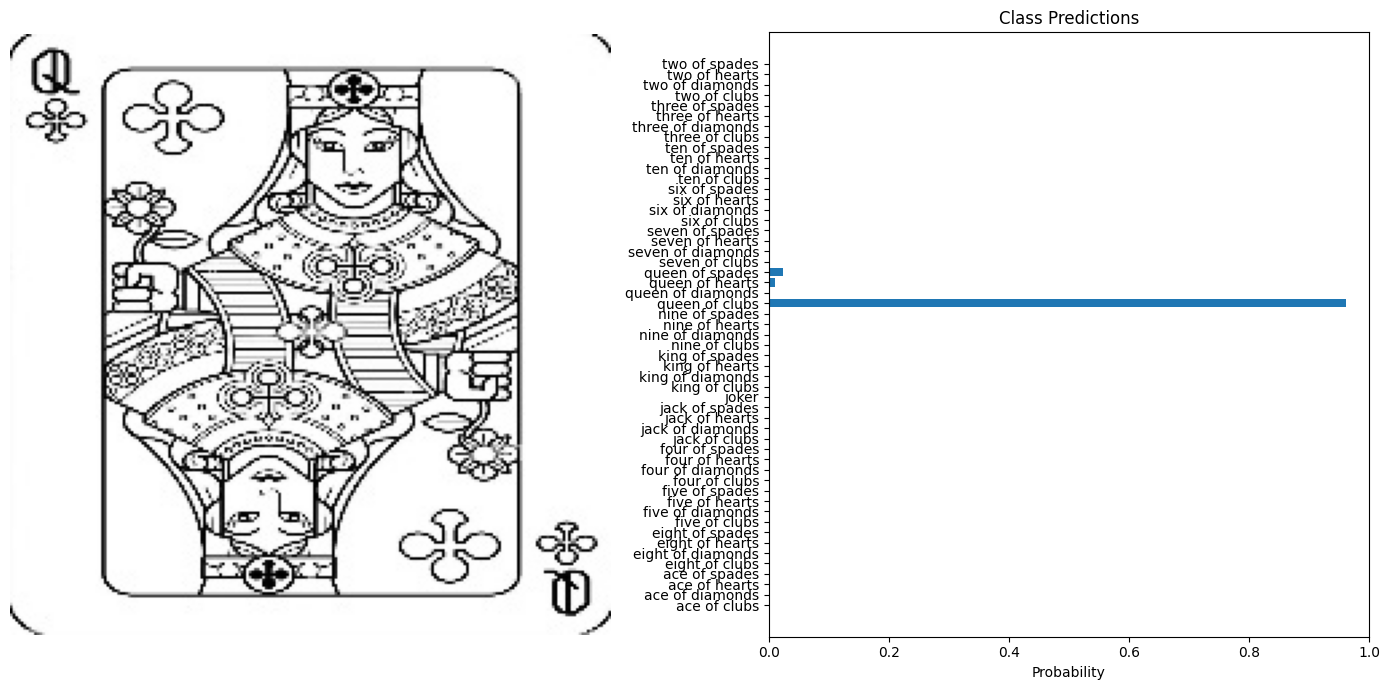

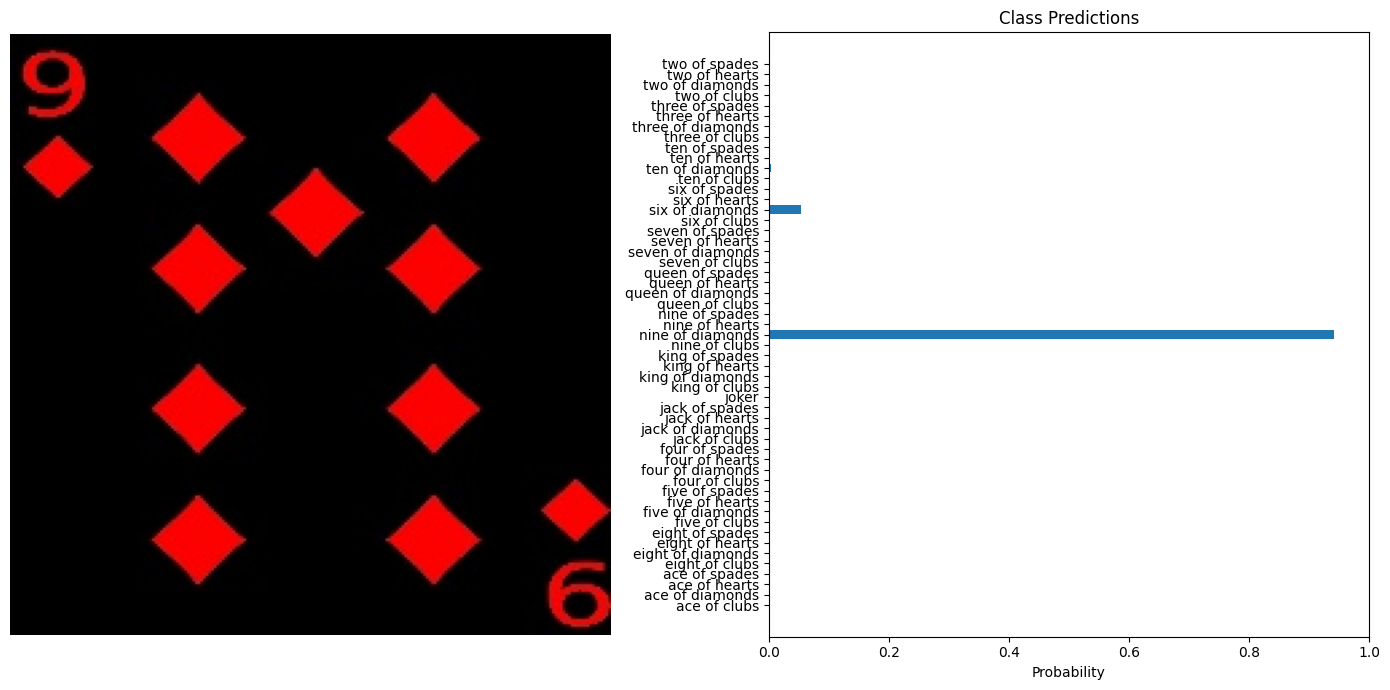

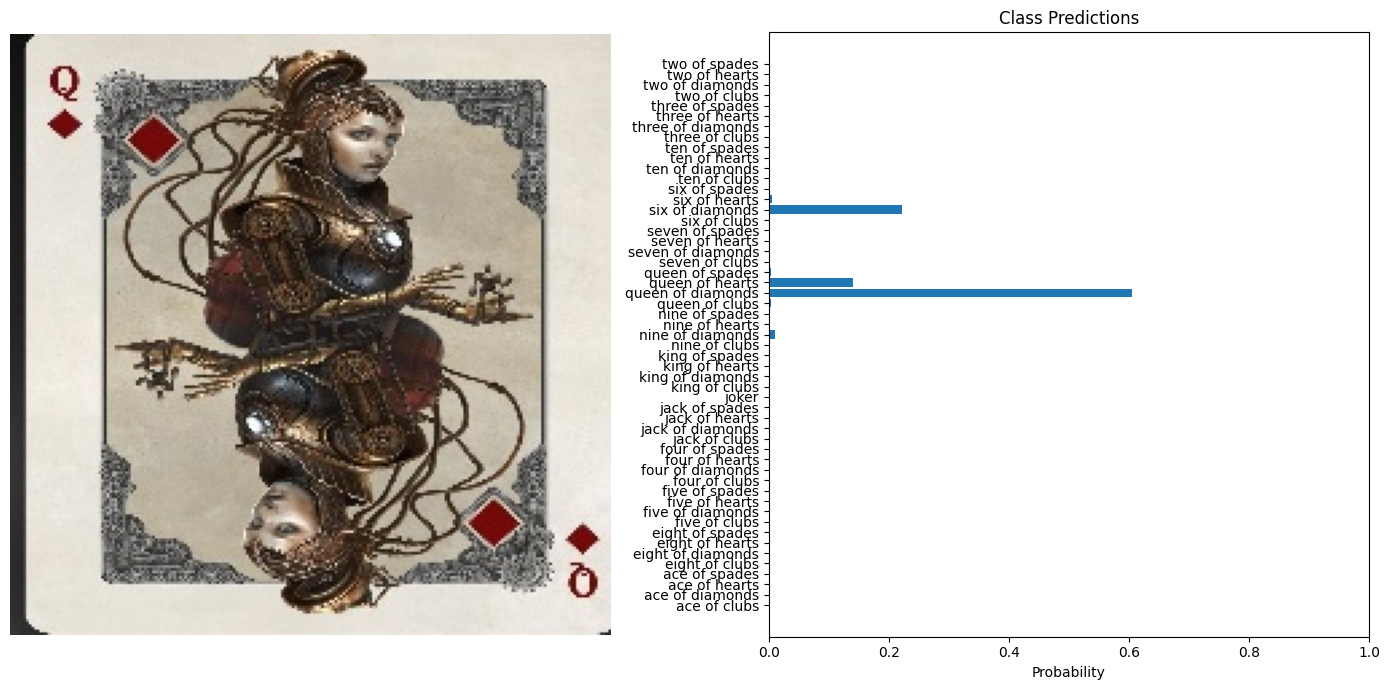

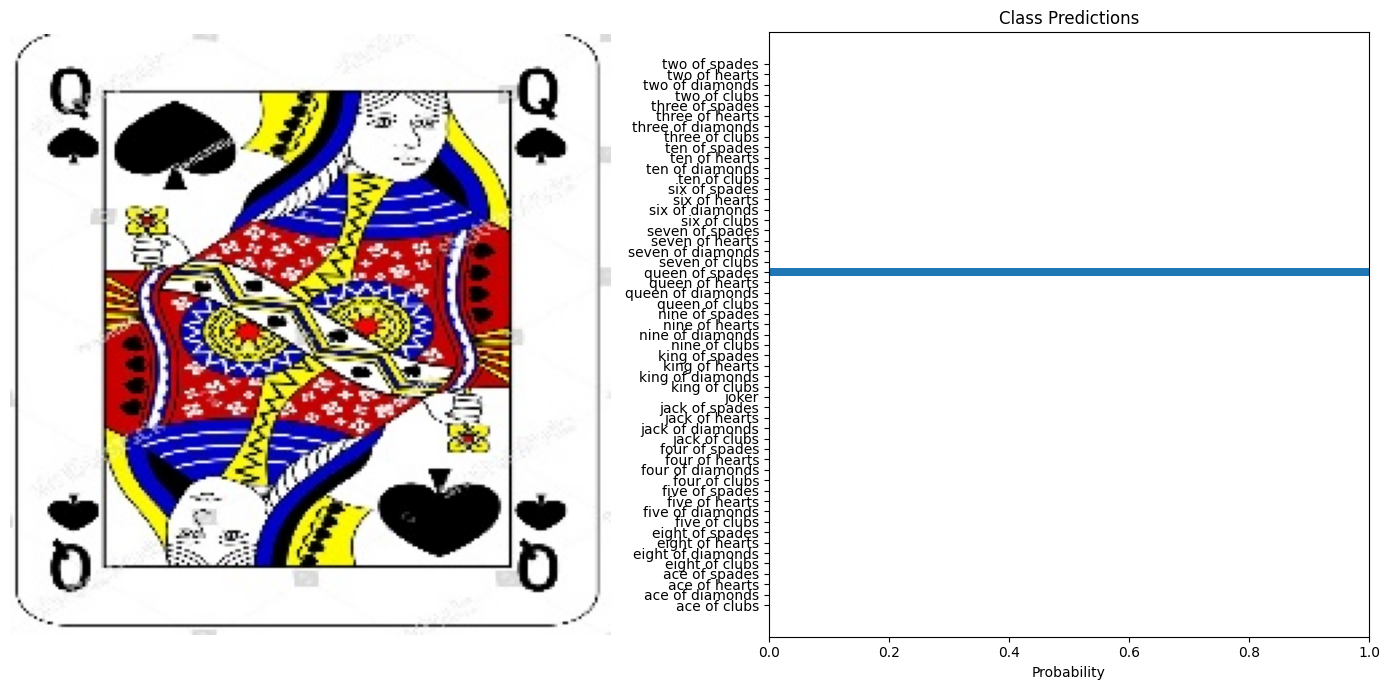

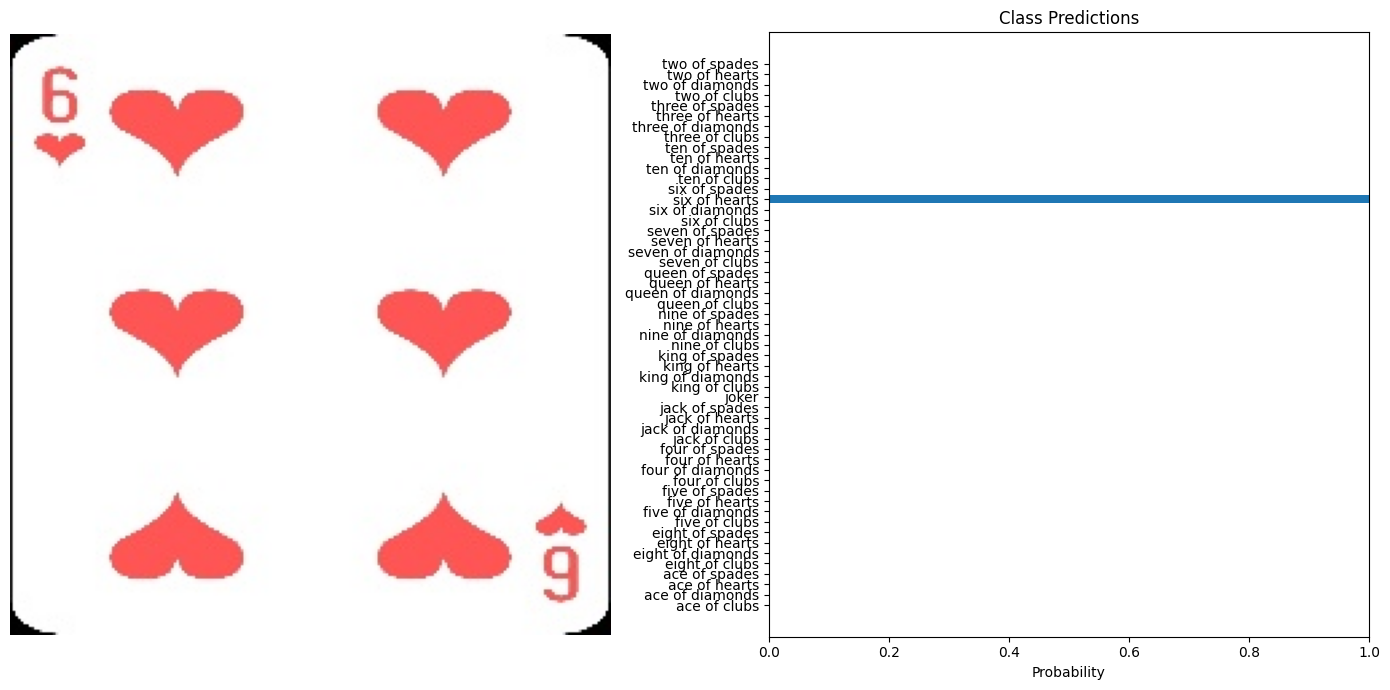

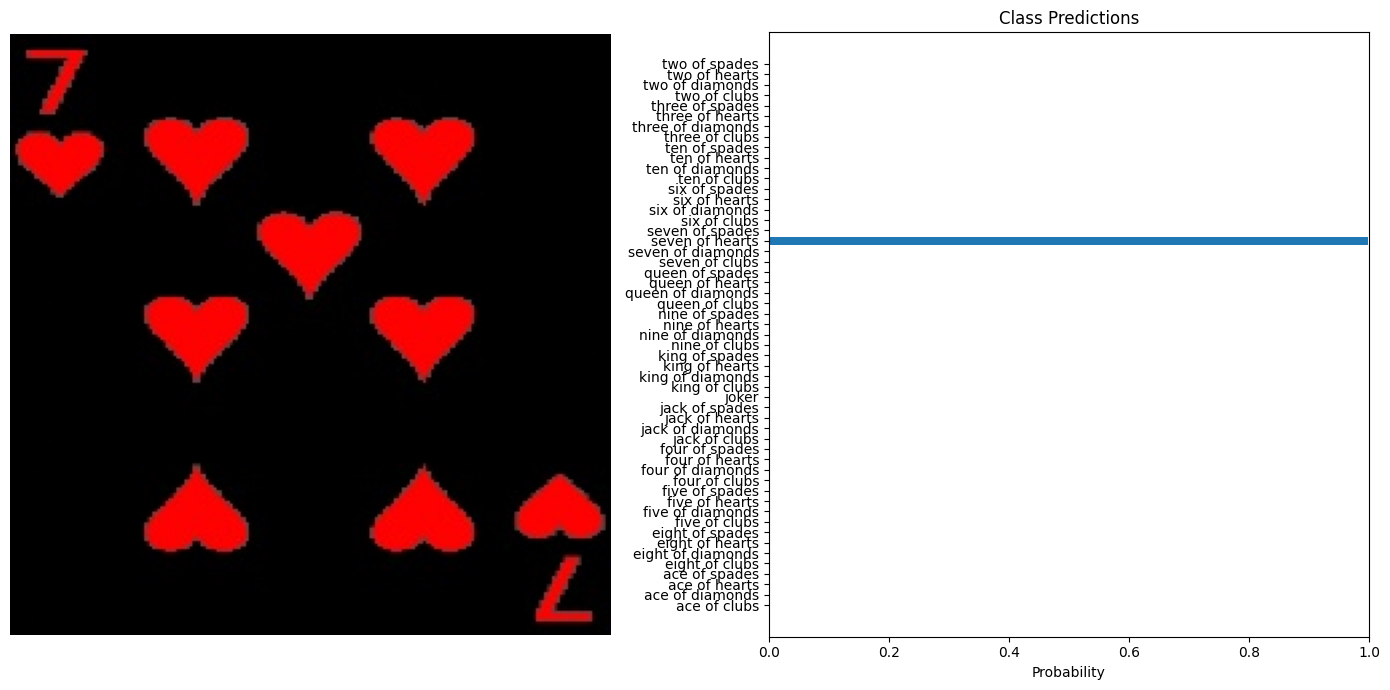

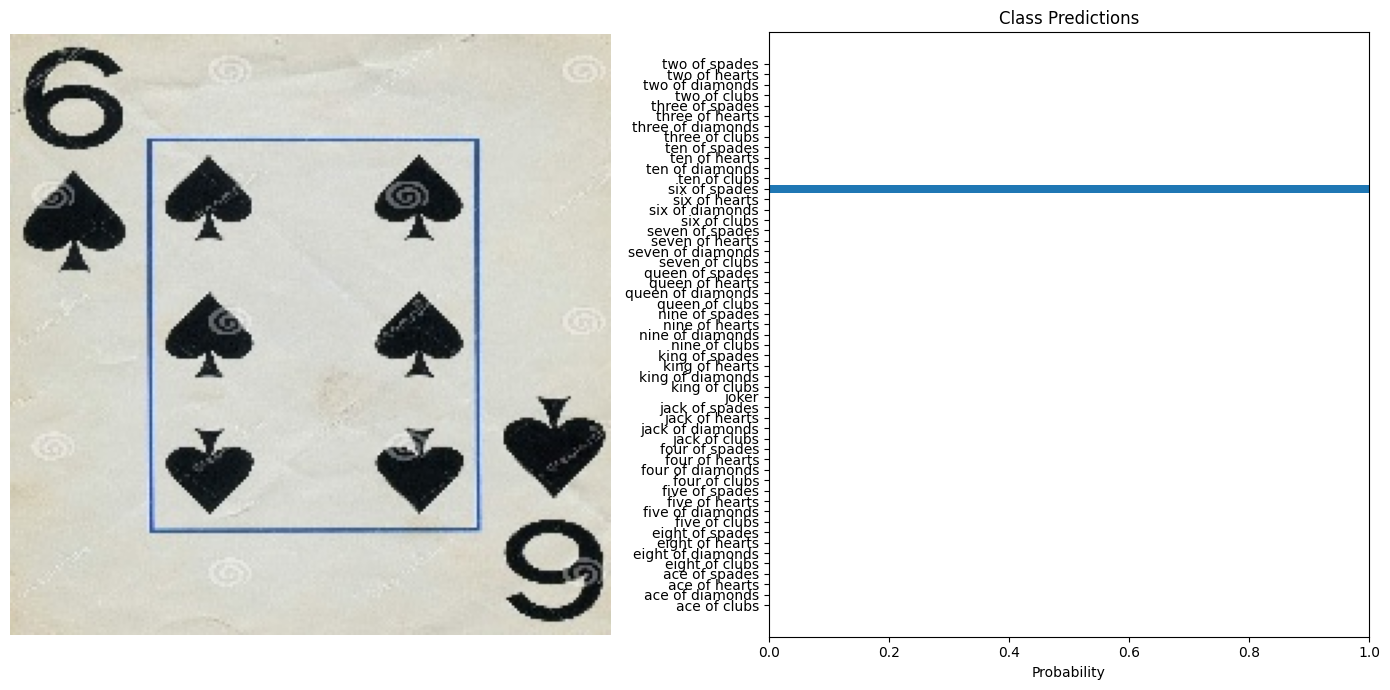

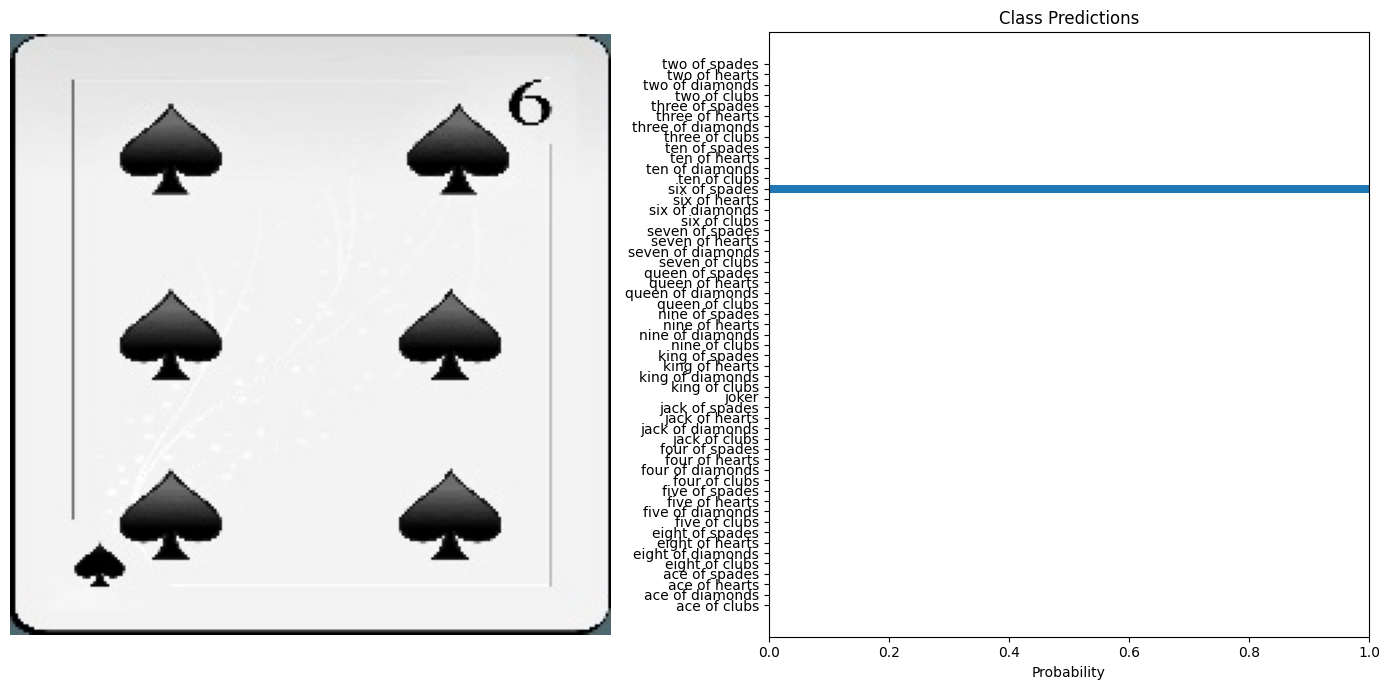

In [115]:
from glob import glob
test_images = glob(path+'/test/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.cFlasses gives the class names
    class_names = train_dataset.classes
    visualize_predictions(original_image, probabilities, class_names)